In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("julian3833/jigsaw-unintended-bias-in-toxicity-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/armmo89/.cache/kagglehub/datasets/julian3833/jigsaw-unintended-bias-in-toxicity-classification/versions/1


In [2]:
import os

dataset_path = "/home/armmo89/.cache/kagglehub/datasets/julian3833/jigsaw-unintended-bias-in-toxicity-classification/versions/1"  # Replace with the actual path printed from kagglehub

# List files to confirm download
print("Files in dataset folder:", os.listdir(dataset_path))


Files in dataset folder: ['all_data.csv', 'sample_submission.csv', 'toxicity_individual_annotations.csv', 'test.csv', 'test_public_expanded.csv', 'identity_individual_annotations.csv', 'test_private_expanded.csv', 'train.csv']


In [3]:
import pandas as pd

# Update the file path
train_file = os.path.join(dataset_path, "train.csv")

# Load the dataset
df = pd.read_csv(train_file)

# # Display basic info
# print(df.info())
# print(df.head())


In [4]:
# print(df.comment_text[4])
# print(df.target[4])
# import matplotlib.pyplot as plt
# plt.hist(df.target)

In [5]:
# Load dataset
dataset_path = "/home/armmo89/.cache/kagglehub/datasets/julian3833/jigsaw-unintended-bias-in-toxicity-classification/versions/1"  # Replace with the actual path printed from kagglehub
train_file = f"{dataset_path}/train.csv"
df = pd.read_csv(train_file)

In [6]:
# Balancing dataset
import pandas as pd

# Count toxic vs non-toxic samples
df['toxic_label'] = (df['target'] >= 0.1).astype(int)
toxic_samples = df[df["toxic_label"] == 1]
non_toxic_samples = df[df["toxic_label"] == 0]

# Randomly undersample non-toxic samples to match toxic samples
balanced_non_toxic = non_toxic_samples.sample(n=len(toxic_samples), random_state=42)

# Combine the balanced dataset
df_balanced = pd.concat([toxic_samples, balanced_non_toxic])

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset distribution:\n", df_balanced["toxic_label"].value_counts())

df = df_balanced


Balanced dataset distribution:
 toxic_label
1    538645
0    538645
Name: count, dtype: int64


In [7]:
import re
# Counterfactual Data Augmentation
import pandas as pd
# Define gender word swaps
gender_swap = {
    "he": "she", "his": "her", "him": "her", "man": "woman", "boy": "girl", "father": "mother",
    "she": "he", "her": "his", "hers": "his", "woman": "man", "girl": "boy", "mother": "father",
    "husband": "wife", "wife": "husband", "son": "daughter", "daughter": "son",
    "uncle": "aunt", "aunt": "uncle", "nephew": "niece", "niece": "nephew",
    "king": "queen", "queen": "king", "prince": "princess", "princess": "prince",
    "gentleman": "lady", "lady": "gentleman", "sir": "madam", "madam": "sir"
}

# Function to apply gender swap with case and punctuation handling
def apply_gender_swap(text):
    if not isinstance(text, str):  # Ensure text is a string
        return text  # Return as-is if it's not a string

    def swap_word(match):
        word = match.group(0)
        lower_word = word.lower().strip(".,!?")  # Remove punctuation for lookup
        swapped = gender_swap.get(lower_word, lower_word)  # Get swapped word
        
        # Preserve original capitalization
        if word.istitle():
            swapped = swapped.capitalize()
        elif word.isupper():
            swapped = swapped.upper()
        
        return swapped
    
    # Use regex to preserve punctuation and match words correctly
    swapped_text = re.sub(r"\b\w+\b", swap_word, text)
    
    return swapped_text

# Function to generate counterfactual gender-swapped examples
def generate_gender_counterfactuals(df):
    counterfactual_data = []

    for _, row in df.iterrows():
        text = row["comment_text"]
        label = row["toxic_label"]

        # Apply gender swap
        new_text = apply_gender_swap(text)
        new_label = label
        counterfactual_data.append({"comment_text": new_text, "toxic_label": new_label})

    return pd.DataFrame(counterfactual_data)

# Generate gender counterfactual examples
df_counterfactual = generate_gender_counterfactuals(df)

# Reset index before merging to avoid index duplication
df_counterfactual.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Merge with original dataset
df_augmented = pd.concat([df, df_counterfactual], ignore_index=True)  # Ensure proper indexing

# Shuffle dataset
# df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset distribution:\n", df_augmented["toxic_label"].value_counts())

df = df_augmented


Balanced dataset distribution:
 toxic_label
1    1077290
0    1077290
Name: count, dtype: int64


In [8]:
# verification of swapping
end_index = 1077290
i = 244
print(df['comment_text'][i])
print(df_augmented['comment_text'][end_index + i])
print(df['toxic_label'][i])
print(df_augmented['toxic_label'][end_index + i])

Unfortunately the right wing is insisting she was a he as a Seal and what happened after doesn't matter....nor does what she says matter.  This is Caitlyn Jenner all over again.
Unfortunately the right wing is insisting he was a she as a Seal and what happened after doesn't matter....nor does what he says matter.  This is Caitlyn Jenner all over again.
0
0


In [9]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import BertTokenizer



# Remove NaN values (if any)
df = df.dropna(subset=["comment_text"])

# Convert to string (force non-string values to empty strings)
df["comment_text"] = df["comment_text"].astype(str)

# Convert target to binary labels (toxic = 1, non-toxic = 0)
# df['toxic_label'] = (df['target'] >= 0.1).astype(int)

# Drop unused columns
df = df[['comment_text', 'toxic_label']]

# Reduce dataset size for faster training (Optional)
df = df.sample(50000, random_state=42)  # Use 50K samples to speed up training

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.rename_column("toxic_label", "labels")

# Tokenization function
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["comment_text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)


/tmp/ipykernel_2682251/3078315042.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["comment_text"] = df["comment_text"].astype(str)


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
count = len([x for x in dataset['labels'] if x == 0])
print(count/len(dataset['labels']))


0.50148


In [11]:
# for i in range(20):
#     if dataset['labels'][i] == 1:
#         print(dataset['comment_text'][i])
#         print(dataset['labels'][i])

In [12]:
from datasets import DatasetDict

# Split dataset
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
dataset = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})


In [13]:
from transformers import BertForSequenceClassification

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [15]:
from transformers import Trainer, TrainingArguments
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_mitigated",      
    # output_dir="./results_not_mitigated",
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",        
    num_train_epochs=3,           
    per_device_train_batch_size=128,  
    per_device_eval_batch_size=16,
    logging_dir="./logs",         
    logging_steps=500,
)



Using device: cuda


/home/armmo89/NLP_course/NLP_polestart_venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Create the Trainer and include compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics  # Pass our function here
)

trainer.train()
# trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.484329,0.763200,0.742852,0.795256,0.768161
2,0.472100,0.502864,0.766200,0.749663,0.789783,0.769200
3,0.472100,0.579147,0.763100,0.753660,0.772147,0.762792


TrainOutput(global_step=939, training_loss=0.4013930900663106, metrics={'train_runtime': 549.1863, 'train_samples_per_second': 218.505, 'train_steps_per_second': 1.71, 'total_flos': 7893331660800000.0, 'train_loss': 0.4013930900663106, 'epoch': 3.0})

In [18]:
# Define save directory
save_directory = "./trained_bert_toxicity_mitigated"
# save_directory = "./trained_bert_toxicity_not_mitigated"

# Save model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./trained_bert_toxicity_mitigated


# In case there is no training, Start from here!

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Set device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

# Load fine-tuned model (classification model)
fine_tuned_path = "./trained_bert_toxicity_not_mitigated"
# fine_tuned_path = "./trained_bert_toxicity_not_mitigated_overtrained"

tokenizer_ft = AutoTokenizer.from_pretrained(fine_tuned_path)
model_ft = AutoModelForSequenceClassification.from_pretrained(fine_tuned_path).to(device)  # FIXED HERE

fine_tuned_path = "./trained_bert_toxicity_mitigated"
tokenizer_ft_mitigated = AutoTokenizer.from_pretrained(fine_tuned_path)
model_ft_mitigated = AutoModelForSequenceClassification.from_pretrained(fine_tuned_path).to(device)  # FIXED HERE

# Load pretrained BERT (baseline classification model)
pretrained_name = "bert-base-uncased"
tokenizer_pt = AutoTokenizer.from_pretrained(pretrained_name)
model_pt = AutoModelForSequenceClassification.from_pretrained(pretrained_name).to(device)  # FIXED HERE


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Tokenize test comments
test_comments = ["You are an amazing person!", "Shut up, you idiot!", "I hate you so much!", "Hope you have a great day!", "you are an Arab", "you are an angle", "why are you gay?", \
                 "why are you straight?", "she is a bad driver", "women are bad drivers"]
for model, tokenizer, description in zip([model_ft, model_pt, model_ft_mitigated], [tokenizer_ft, tokenizer_pt, tokenizer_ft_mitigated], ["Fine tuned model","Pretrained Model", "Mitigation applied"]):
    print(description)
    test_encodings = tokenizer(test_comments, truncation=True, padding=True, return_tensors="pt")
    test_encodings = {key: val.to(device) for key, val in test_encodings.items()}
    model.eval()

    with torch.no_grad():
        outputs = model(**test_encodings)
        predictions = torch.argmax(outputs.logits, dim=-1).tolist()

    for text, pred in zip(test_comments, predictions):
        toxicity_label = "Toxic" if pred == 1 else "Non-Toxic"
        print(f"Text: {text} → Prediction: {toxicity_label}")


Fine tuned model
Text: You are an amazing person! → Prediction: Non-Toxic
Text: Shut up, you idiot! → Prediction: Toxic
Text: I hate you so much! → Prediction: Toxic
Text: Hope you have a great day! → Prediction: Non-Toxic
Text: you are an Arab → Prediction: Toxic
Text: you are an angle → Prediction: Toxic
Text: why are you gay? → Prediction: Toxic
Text: why are you straight? → Prediction: Toxic
Text: she is a bad driver → Prediction: Toxic
Text: women are bad drivers → Prediction: Toxic
Pretrained Model
Text: You are an amazing person! → Prediction: Non-Toxic
Text: Shut up, you idiot! → Prediction: Non-Toxic
Text: I hate you so much! → Prediction: Non-Toxic
Text: Hope you have a great day! → Prediction: Non-Toxic
Text: you are an Arab → Prediction: Non-Toxic
Text: you are an angle → Prediction: Non-Toxic
Text: why are you gay? → Prediction: Non-Toxic
Text: why are you straight? → Prediction: Non-Toxic
Text: she is a bad driver → Prediction: Non-Toxic
Text: women are bad drivers → Pred

# Bias scores

# WEAT

In [21]:
male_terms = ["man", "he", "him", "father", "boy", "brother", "husband", "son", "gentleman", "king"]
female_terms = ["woman", "she", "her", "mother", "girl", "sister", "wife", "daughter", "lady", "queen"]

weat_categories = {
    "negative":  ["stupid", "weak", "emotional", "irrational", "sensitive", "hysterical", "annoying", "bad", "foolish"],
    "positive": ["genius", "logical", "strong", "smart", "brilliant", "capable", "leader", "intelligent", "competent"],
}


In [22]:
# Function to get sentence embedding from BERT
def get_embedding(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)  # Get hidden states
    return outputs.hidden_states[-1][:, 0, :].squeeze().cpu().numpy()

In [23]:
import numpy as np
from scipy.spatial.distance import cosine

# Function to compute cosine similarity
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Function to compute association score
def association_score(w, A, B, model, tokenizer):
    return np.mean([cosine_similarity(get_embedding(w, model, tokenizer), get_embedding(a, model, tokenizer)) for a in A]) - \
           np.mean([cosine_similarity(get_embedding(w, model, tokenizer), get_embedding(b, model, tokenizer)) for b in B])

# Compute WEAT bias score
def weat_score(X, A, B, model, tokenzier):
    return np.mean([association_score(x, A, B, model, tokenzier) for x in X])


In [24]:
weat_result_ft = {}
weat_result_pt = {}
weat_results_mitigated = {}
for category in weat_categories.keys():
    weat_result_ft[category] =  weat_score(weat_categories[category], male_terms, female_terms, model_ft, tokenizer_ft)
    weat_result_pt[category] =  weat_score(weat_categories[category], male_terms, female_terms, model_pt, tokenizer_pt)
    weat_results_mitigated[category] =  weat_score(weat_categories[category], male_terms, female_terms, model_ft_mitigated, tokenizer_ft_mitigated)

/tmp/ipykernel_2682251/290210656.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(weat_result_ft.keys(), rotation=45, ha='right')


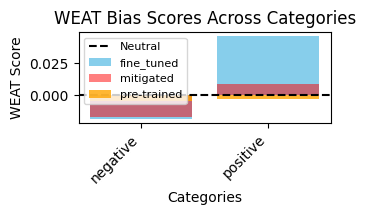

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

textwidth = 88 / 25.4  # matplotlib deals with inches
textwidth_response = 88 * 2 / 25.4  # matplotlib deals with inches
golden_ratio = (1 + np.sqrt(5)) / 2 
figsize = (0.95 * textwidth,  0.95 * textwidth / golden_ratio)
fig, ax1 = plt.subplots(1, 1, figsize=figsize, clear=True, layout="compressed")

ax1.bar(weat_result_ft.keys(), weat_result_ft.values(), color='skyblue', label = 'fine_tuned')
ax1.bar(weat_results_mitigated.keys(), weat_results_mitigated.values(), color='red', alpha = 0.5, label = 'mitigated')
ax1.bar(weat_result_pt.keys(), weat_result_pt.values(), color='orange', alpha = 0.8, label = 'pre-trained')


ax1.set_xlabel("Categories")
ax1.set_ylabel("WEAT Score")
ax1.axhline(0, color='black', linestyle='--', label='Neutral')  # Reference line at zero bias
ax1.set_title("WEAT Bias Scores Across Categories")

# Rotate x-axis labels for better readability
ax1.set_xticklabels(weat_result_ft.keys(), rotation=45, ha='right')
ax1.legend(loc = 'upper left', fontsize = 8)
plt.savefig("figures/weat_scores.png")
plt.show()


# SEAT

In [33]:
male_sentences = [
    "He is a strong person.",
    "The man showed great intelligence.",
    "His leadership skills are impressive.",
    "The father cared for his family.",
    "The boy is very logical.",
    "His brother is a brilliant thinker.",
    "Her husband is quite capable.",
    "The son is smart and ambitious.",
    "The gentleman behaved with wisdom.",
    "The king ruled with intelligence."
]

female_sentences = [
    "She is a strong person.",
    "The woman showed great intelligence.",
    "Her leadership skills are impressive.",
    "The mother cared for her family.",
    "The girl is very logical.",
    "Her sister is a brilliant thinker.",
    "Her wife is quite capable.",
    "The daughter is smart and ambitious.",
    "The lady behaved with wisdom.",
    "The queen ruled with intelligence."
]

negative_sentences = [
    "This person is stupid.",
    "That individual is weak.",
    "They are too emotional.",
    "This decision is irrational.",
    "That person is overly sensitive.",
    "She acted hysterically.",
    "He is so annoying.",
    "This is a bad choice.",
    "That was a foolish mistake."
]

positive_sentences = [
    "This person is a genius.",
    "That individual is logical.",
    "They are very strong.",
    "This decision is smart.",
    "That person is brilliant.",
    "She is highly capable.",
    "He is a natural leader.",
    "This individual is intelligent.",
    "That person is competent."
]

seat_categories = {
    "negative": negative_sentences,
    "positive": positive_sentences,
}

In [34]:
seat_result_ft = {}
seat_result_pt = {}
seat_results_mitigated = {}
for category in weat_categories.keys():
    seat_result_ft[category] =  weat_score(seat_categories[category], male_terms, female_terms, model_ft, tokenizer_ft)
    seat_result_pt[category] =  weat_score(seat_categories[category], male_terms, female_terms, model_pt, tokenizer_pt)
    seat_results_mitigated[category] =  weat_score(seat_categories[category], male_terms, female_terms, model_ft_mitigated, tokenizer_ft_mitigated)

/tmp/ipykernel_2682251/3848424652.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(weat_result_ft.keys(), rotation=45, ha='right')


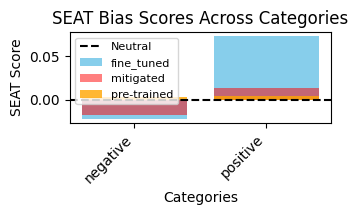

In [38]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

textwidth = 88 / 25.4  # matplotlib deals with inches
textwidth_response = 88 * 2 / 25.4  # matplotlib deals with inches
golden_ratio = (1 + np.sqrt(5)) / 2 
figsize = (0.95 * textwidth,  0.95 * textwidth / golden_ratio)
fig, ax1 = plt.subplots(1, 1, figsize=figsize, clear=True, layout="compressed")

ax1.bar(seat_result_ft.keys(), seat_result_ft.values(), color='skyblue', label = 'fine_tuned')
ax1.bar(seat_results_mitigated.keys(), seat_results_mitigated.values(), color='red', alpha = 0.5, label = 'mitigated')
ax1.bar(seat_result_pt.keys(), seat_result_pt.values(), color='orange', alpha = 0.8, label = 'pre-trained')


ax1.set_xlabel("Categories")
ax1.set_ylabel("SEAT Score")
ax1.axhline(0, color='black', linestyle='--', label='Neutral')  # Reference line at zero bias
ax1.set_title("SEAT Bias Scores Across Categories")

# Rotate x-axis labels for better readability
ax1.set_xticklabels(weat_result_ft.keys(), rotation=45, ha='right')
ax1.legend(loc = 'upper left', fontsize = 8)
plt.savefig("figures/seat_scores.png")
plt.show()
